In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
from datetime import datetime
import gensim
from gensim.models.phrases import Phrases, Phraser
import pandas as pd
import numpy as np
import seaborn as sns

from cord19.utils.utils import flatten_lists, clean_and_tokenize

# Remove this if you use use data_getters and just import get_engine
from sqlalchemy import create_engine
from sqlalchemy.engine.url import URL
from configparser import ConfigParser
def get_engine(config_path, database="production", **engine_kwargs):
    '''Get a SQL alchemy engine from config'''
    cp = ConfigParser()
    cp.read(config_path)
    cp = cp["client"]
    url = URL(drivername="mysql+pymysql", database=database,
              username=cp["user"], host=cp["host"], password=cp["password"])
    return create_engine(url, **engine_kwargs)

## Read bioRxiv, medRxiv and arXiv data and identify COVID-19 papers using this [query](https://arxiv.org/search/advanced?advanced=&terms-0-operator=AND&terms-0-term=COVID-19&terms-0-field=title&terms-1-operator=OR&terms-1-term=SARS-CoV-2&terms-1-field=abstract&terms-3-operator=OR&terms-3-term=COVID-19&terms-3-field=abstract&terms-4-operator=OR&terms-4-term=SARS-CoV-2&terms-4-field=title&terms-5-operator=OR&terms-5-term=coronavirus&terms-5-field=title&terms-6-operator=OR&terms-6-term=coronavirus&terms-6-field=abstract&classification-physics_archives=all&classification-include_cross_list=include&date-filter_by=all_dates&date-year=&date-from_date=&date-to_date=&date-date_type=submitted_date&abstracts=show&size=200&order=-announced_date_first&source=home-covid-19)

title=COVID-19; OR abstract=SARS-CoV-2; OR abstract=COVID-19; OR title=SARS-CoV-2; OR title=coronavirus; OR abstract=coronavirus

In [5]:
%%time
columns=['id', 'created', 'title', 'abstract', 'mag_id', 'citation_count', 'article_source']
con = get_engine("../../innovation-mapping-5712.config")
chunks = pd.read_sql_table('arxiv_articles', con, columns=columns, chunksize=1000)

keywords = ('SARS-CoV-2', 'COVID-19', 'coronavirus')

covid_df = []
for i, df in enumerate(chunks):    
    covid_abstract = df.abstract.apply(lambda text: text is not None and any(term in text for term in keywords))
    covid_title = df.title.apply(lambda text: text is not None and any(term in text for term in keywords))

    ids = []
    ids.extend(list(covid_abstract.where(covid_abstract==True).dropna().index))
    ids.extend(list(covid_title.where(covid_title==True).dropna().index))
    
    if len(ids) == 0:
        continue
    covid_df.append(df.loc[set(ids)])
    
covid_df = pd.concat(covid_df)

CPU times: user 1min 37s, sys: 12.5 s, total: 1min 49s
Wall time: 5min 36s


In [6]:
covid_df.shape

(2628, 7)

In [7]:
covid_df.article_source.value_counts()

medrxiv    1452
arxiv       690
biorxiv     486
Name: article_source, dtype: int64

In [8]:
covid_df.head(2)

,id,created,title,abstract,mag_id,citation_count,article_source
142,1311.1481,2013-11-06,Assessment of the MERS-CoV epidemic situation ...,The appearance of a novel coronavirus named ...,1.960787e+09,3.0,arxiv
12,1412.4034,2014-12-12,Feline coronaviruses associated with feline in...,Feline infectious peritonitis (FIP) is assoc...,1.584918e+09,0.0,arxiv


## Data processing

In [9]:
covid_df['year'] = covid_df.created.apply(lambda x: x.year)
covid_df['month_year'] = pd.to_datetime(covid_df['created']).dt.to_period('M')

## Exploratory data analysis

In [10]:
(covid_df.isnull().sum() / covid_df.shape[0]) * 100

id                 0.000000
created            0.000000
title              0.000000
abstract           0.152207
mag_id            13.660578
citation_count     8.105023
article_source     0.000000
year               0.000000
month_year         0.000000
dtype: float64

In [11]:
print(f'% of papers published in 2020: {covid_df[covid_df.year==2020].shape[0] / covid_df.shape[0]}')

% of papers published in 2020: 0.980593607305936


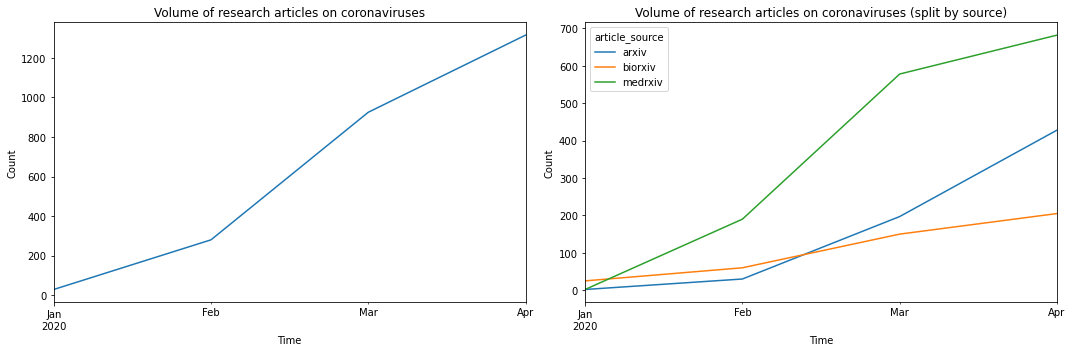

In [12]:
f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5))

# Today's year and month
today = datetime.today()
datem = datetime(today.year, today.month, 1)
datem = pd.to_datetime(datem).to_period('M')

# ax1
m = covid_df[(covid_df.year == 2020) & (covid_df.month_year < datem)].groupby("month_year")['id'].count()
m.plot(ax=ax1)
ax1.set_xlabel('Time')
ax1.set_title('Volume of research articles on coronaviruses')
ax1.set_ylabel('Count')


# ax2
m = covid_df[(covid_df.year == 2020) & (covid_df.month_year < datem)].groupby(["article_source", "month_year"])['id'].count().unstack('article_source')
m.plot(ax=ax2)
ax2.set_xlabel('Time')
ax2.set_title('Volume of research articles on coronaviruses (split by source)')
ax2.set_ylabel('Count')

f.tight_layout()
plt.show()

## Preprocess abstracts

In [13]:
# Drop papers without an abstract
covid_papers = covid_df.dropna(subset=['abstract'])

# Tokenise paper abstracts
abstracts = [clean_and_tokenize(d, remove_stops=True) for d in covid_papers.abstract]

In [14]:
# Create trigrams
phrases = Phrases(abstracts, min_count=5, threshold=10)
bigram = Phraser(phrases)
trigram = Phrases(bigram[abstracts], min_count=5, threshold=1)
abstracts_with_ngrams = list(trigram[abstracts])

2020-05-06 14:39:29,273 - gensim.models.phrases - INFO - collecting all words and their counts
2020-05-06 14:39:29,273 - gensim.models.phrases - INFO - PROGRESS: at sentence #0, processed 0 words and 0 word types
2020-05-06 14:39:29,677 - gensim.models.phrases - INFO - collected 219221 word types from a corpus of 311055 words (unigram + bigrams) and 2624 sentences
2020-05-06 14:39:29,678 - gensim.models.phrases - INFO - using 219221 counts as vocab in Phrases<0 vocab, min_count=5, threshold=10, max_vocab_size=40000000>
2020-05-06 14:39:29,679 - gensim.models.phrases - INFO - source_vocab length 219221
2020-05-06 14:39:31,215 - gensim.models.phrases - INFO - Phraser built with 2353 phrasegrams
2020-05-06 14:39:31,216 - gensim.models.phrases - INFO - collecting all words and their counts
2020-05-06 14:39:31,217 - gensim.models.phrases - INFO - PROGRESS: at sentence #0, processed 0 words and 0 word types
2020-05-06 14:39:32,083 - gensim.models.phrases - INFO - collected 233039 word types 

## Find ML papers

In [15]:
w2v = gensim.models.Word2Vec(abstracts_with_ngrams, size=300, window=10, min_count=5, seed=42, iter=10)
# Found the following keywords by querying the word2vec model with ML tokens
# w2v.wv.most_similar(['machine_learning'], topn=30)
ml_keywords = [
    'optimization_algorithm', 'convolutional_neural', 'automatic_detection', 'transfer_learning', 
    'semi_supervised', 'dnn', 'pre_trained', 'artificial_intelligence', 'natural_language', 
    'deep_learning', 'machine_learning', 'training_dataset', 'covid_net', 'classification', 
    'cnn', 'learning_based', 'deep_neural', 'neural_network', 'feature_extraction', 'deep_convolutional',
]

2020-05-06 14:39:32,911 - gensim.models.word2vec - INFO - collecting all words and their counts
2020-05-06 14:39:32,912 - gensim.models.word2vec - INFO - PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-05-06 14:39:32,960 - gensim.models.word2vec - INFO - collected 21373 word types from a corpus of 267727 raw words and 2624 sentences
2020-05-06 14:39:32,961 - gensim.models.word2vec - INFO - Loading a fresh vocabulary
2020-05-06 14:39:32,998 - gensim.models.word2vec - INFO - effective_min_count=5 retains 8801 unique words (41% of original 21373, drops 12572)
2020-05-06 14:39:32,999 - gensim.models.word2vec - INFO - effective_min_count=5 leaves 246729 word corpus (92% of original 267727, drops 20998)
2020-05-06 14:39:33,019 - gensim.models.word2vec - INFO - deleting the raw counts dictionary of 21373 items
2020-05-06 14:39:33,020 - gensim.models.word2vec - INFO - sample=0.001 downsamples 15 most-common words
2020-05-06 14:39:33,021 - gensim.models.word2vec - INFO - 

In [16]:
is_ai = []
for i, tokens in enumerate(abstracts_with_ngrams):
    if any(k in tokens for k in ml_keywords):
        is_ai.append(1)
    else:
        is_ai.append(0)
        
covid_papers['is_AI'] = is_ai

<ipython-input-16-4b2b25dd780b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid_papers['is_AI'] = is_ai


In [17]:
print(f'Total AI papers published in 2020: {covid_papers[(covid_papers.year==2020) & (covid_papers.is_AI==1)].shape[0] }')

Total AI papers published in 2020: 215


I found this many AI papers in the covid-19 dataset:
- arxiv: 132
- medrxiv: 61
- biorxiv: 24

This is more or less aligned with a similar exploration I did in the CORD19 dataset where I found this number of AI papers by following a previously used [keyword matching approach](https://arxiv.org/abs/2003.11336):
- medrxiv: 60
- biorxiv: 28

(Note: arXiv is not part of CORD19)

In [18]:
covid_papers[covid_papers['is_AI']==1].article_source.value_counts()

arxiv      132
medrxiv     61
biorxiv     24
Name: article_source, dtype: int64

#### Volume of AI publications in 2020

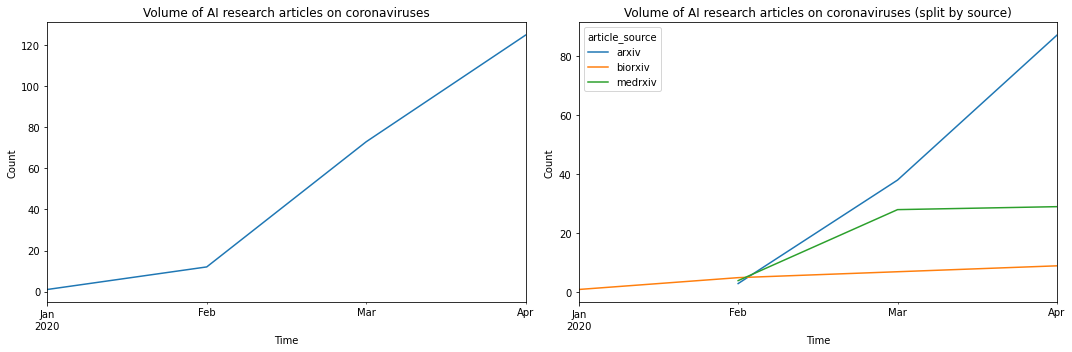

In [19]:
f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5))

# Today's year and month
today = datetime.today()
datem = datetime(today.year, today.month, 1)
datem = pd.to_datetime(datem).to_period('M')

# ax1
m = covid_papers[(covid_papers.year == 2020) & (covid_papers.month_year < datem) & (covid_papers.is_AI==1)].groupby("month_year")['id'].count()
m.plot(ax=ax1)
ax1.set_xlabel('Time')
ax1.set_title('Volume of AI research articles on coronaviruses')
ax1.set_ylabel('Count')


# ax2
m = covid_papers[(covid_papers.year == 2020) & (covid_papers.month_year < datem) & (covid_papers.is_AI==1)].groupby(["article_source", "month_year"])['id'].count().unstack('article_source')
m.plot(ax=ax2)
ax2.set_xlabel('Time')
ax2.set_title('Volume of AI research articles on coronaviruses (split by source)')
ax2.set_ylabel('Count')

f.tight_layout()
plt.show()

## Identifying thematic topics

We use Gensim's LDA.

In [23]:
# Create dictionary
dictionary = gensim.corpora.Dictionary(abstracts_with_ngrams)

# Create BoW
bow = [dictionary.doc2bow(document) for document in abstracts_with_ngrams]

2020-05-06 14:41:12,680 - gensim.corpora.dictionary - INFO - adding document #0 to Dictionary(0 unique tokens: [])
2020-05-06 14:41:12,965 - gensim.corpora.dictionary - INFO - built Dictionary(21373 unique tokens: ['alertness', 'allows', 'analyses', 'analysis', 'analysis_provides']...) from 2624 documents (total 267727 corpus positions)


In [ ]:
%%time
# Train multicore LDA
lda_model = gensim.models.LdaMulticore(corpus=bow, 
                                       id2word=dictionary, 
                                       num_topics=10,
                                       passes=20,
                                       alpha='asymmetric', 
                                       eta='auto',
                                       iterations=150
                                      )

In [ ]:
# lda_model = gensim.models.LdaMulticore.load('../../models/lda_10_20_150.lda')

In [20]:
for topic_num, words in lda_model.show_topics(-1, formatted=False):
    print(f'Topic: {topic_num}')
    print([word[0] for word in words])

Topic: 0
['infection', 'patients', 'reported', 'cases', 'disease', 'results', 'infections', 'data', 'time', 'number']
Topic: 1
['virus', 'human', 'cells', 'coronavirus', 'viral', 'protein', 'infection', 'sars_cov', 'potential', 'found']
Topic: 2
['cases', 'china', 'outbreak', 'data', 'model', 'time', 'number', 'based', 'countries', 'disease']
Topic: 3
['patients', 'treatment', 'cases', 'group', 'disease', 'admission', 'results', 'compared', 'infection', 'age']
Topic: 4
['cases', 'china', 'wuhan', 'outbreak', 'epidemic', 'transmission', 'estimated', 'data', 'cfr', 'results']
Topic: 5
['model', 'data', 'using', 'cases', 'models', 'based', 'also', 'results', 'method', 'well']
Topic: 6
['pandemic', 'samples', 'trials', 'using', 'use', 'methods', 'control', 'research', 'patients', 'results']
Topic: 7
['model', 'epidemic', 'data', 'social_distancing', 'pandemic', 'measures', 'countries', 'population', 'time', 'lockdown']
Topic: 8
['symptoms', 'patients', 'cases', 'data', 'influenza', 'infect

In [21]:
# lda_model.save('../../models/lda_10_20_150.lda')

In [24]:
# Create an empty dataframe
covid_topics = pd.DataFrame(0, index=covid_papers.index, columns=[tup[0] for tup in lda_model.show_topics(-1)])

# Populate the empty dataframe with topics and their proportions
for i, bag_of_words in enumerate(bow):
    doc_topics = lda_model.get_document_topics(bag_of_words)
    for doc_topic in doc_topics:
        covid_topics.iloc[i, doc_topic[0]] = doc_topic[1]
        
covid_papers = pd.concat([covid_papers, covid_topics], axis=1)

#### Most used topics in AI papers

Topic 9 is the most used one in the AI subset of the COVID-19 papers. That's reasonable. Some of the high-probable words in Topic 9 are "deep learning" and "dataset".

I also did a very basic attempt to check if there are any correlated topics - doesn't look like.

In [25]:
# Sum of topic proportions for the AI subset
covid_papers[covid_papers.is_AI==1].iloc[:, 10:].sum()

0    21.086159
1    28.625230
2    17.616257
3    13.077540
4     2.923149
5    11.157137
6     5.624152
7    29.463474
8     4.048002
9    81.598248
dtype: float64

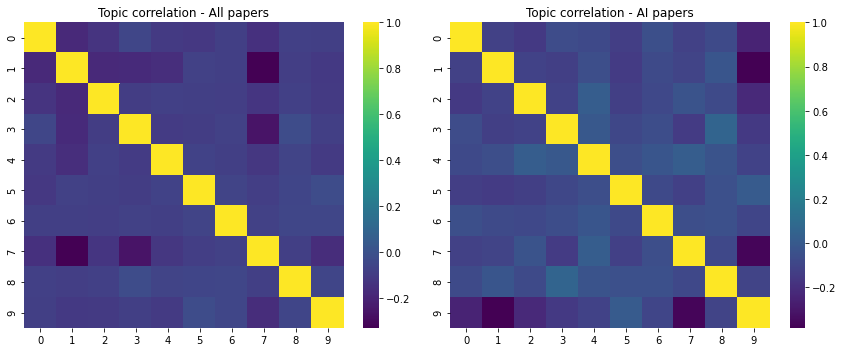

In [26]:
f, (ax1,ax2) = plt.subplots(ncols=2, figsize=(12,5))

# All papers
sns.heatmap(covid_papers.iloc[:, 10:].corr(), cmap='viridis', ax=ax1)
ax1.set_title('Topic correlation - All papers')

# AI subset
sns.heatmap(covid_papers[covid_papers.is_AI==1].iloc[:, 10:].corr(), cmap='viridis', ax=ax2)
ax2.set_title('Topic correlation - AI papers')

f.tight_layout()
plt.show()

To measure the activity in thematic topics, I will do the following:
- Label a topic by its top 4 words (ie the ones with the highest probability of occurring in that topic)
- Binarize them (1=topic proportion larger than .1, 0=topic proportion smaller than .1)

In [27]:
# Topic labelling
topic_label_mapping = {}
for topic_num, words in lda_model.show_topics(-1, formatted=False):
    topic_label_mapping[topic_num] = '_'.join([word[0] for word in words][:4])

In [28]:
topic_label_mapping

{0: 'infection_patients_reported_cases',
 1: 'virus_human_cells_coronavirus',
 2: 'cases_china_outbreak_data',
 3: 'patients_treatment_cases_group',
 4: 'cases_china_wuhan_outbreak',
 5: 'model_data_using_cases',
 6: 'pandemic_samples_trials_using',
 7: 'model_epidemic_data_social_distancing',
 8: 'symptoms_patients_cases_data',
 9: 'using_detection_images_diagnosis'}

In [29]:
# Binarise topics
binary_topics = covid_papers.iloc[:, 10:].where(covid_papers.iloc[:, 10:] < 0.1).fillna(1)

# Concant binary topics with original papers
covid_papers_binary_topics = pd.concat([covid_papers.iloc[:, :10], binary_topics], axis=1)

# Rename topics using the mapping
covid_papers_binary_topics.rename(index=str, inplace=True, columns=topic_label_mapping)

# Keep only AI publications
ai_papers = covid_papers_binary_topics[covid_papers_binary_topics.is_AI==1]

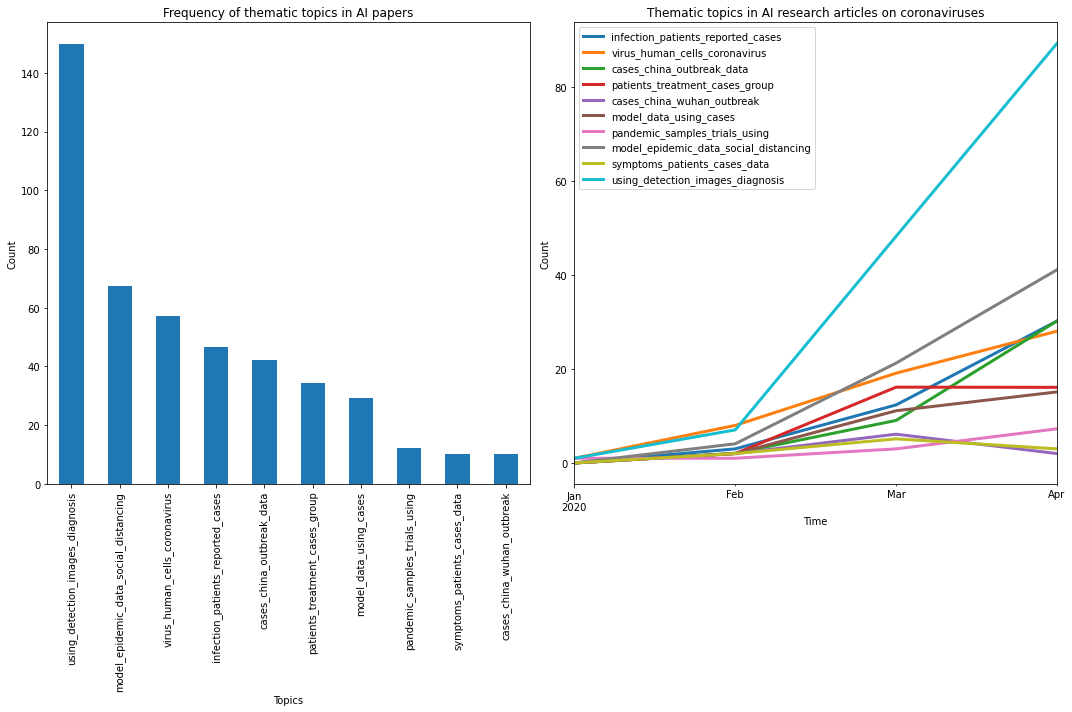

In [30]:
f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,10))

# Today's year and month
today = datetime.today()
datem = datetime(today.year, today.month, 1)
datem = pd.to_datetime(datem).to_period('M')

# ax1
ai_papers[ai_papers.year==2020].iloc[:, 10:].sum().sort_values(ascending=False).plot(kind='bar', ax=ax1)
ax1.set_xlabel('Topics')
ax1.set_title('Frequency of thematic topics in AI papers')
ax1.set_ylabel('Count')


# ax2
m = ai_papers[(ai_papers.year == 2020) & (ai_papers.month_year < datem)].groupby(["month_year"])[list(topic_label_mapping.values())].sum()
m.plot(ax=ax2, linewidth=3)
ax2.set_xlabel('Time')
ax2.set_title('Thematic topics in AI research articles on coronaviruses')
ax2.set_ylabel('Count')

f.tight_layout()
plt.show()